In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
# need to set gpus before anything involving pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

import torch
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from tqdm import tqdm

os.chdir('/data7/brandon/research/DA_MVR/occ_net/occupancy_networks')
from im2mesh import config
from im2mesh.checkpoints import CheckpointIO

In [57]:
# da is a boolean indicating to use the target dataset or not
def get_latent_vecs(config_yaml, da):
    device = torch.device("cuda")
    cfg = config.load_config(config_yaml, 'configs/default.yaml')
    
    dataset = config.get_dataset('test', cfg, return_idx=True, use_target_domain = da)
    model = config.get_model(cfg, device=device, dataset=dataset)
    out_dir = cfg['training']['out_dir']
    checkpoint_io = CheckpointIO(out_dir, model=model)
    # load with 'cuda:0' because we set visible devices earlier
    checkpoint_io.load(cfg['test']['model_file'], 'cuda:0')
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    model.eval()
    
    latent_vecs = []
    for it, data in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            inputs = data.get('inputs', torch.empty(1, 0)).to(device)
            c = model.encode_inputs(inputs)
            latent_vecs.append(c.cpu().detach().numpy())
            #if it > 5:
            #    break
            
    latent_vecs = np.concatenate(latent_vecs,0)
    return latent_vecs

In [51]:
def embed_TSNE(data):
    X_embedded = data
    #X_embedded = PCA(n_components = 50, svd_solver='auto').fit_transform(X_embedded)
    X_embedded = TSNE(n_components=2).fit_transform(X_embedded) 
    return X_embedded

def visualize_tsne(embedded_latent_vectors, class_labels, title="TSNE"):
    
    embedded_df = pd.DataFrame(embedded_latent_vectors) 
    ax = embedded_df.plot.scatter(x=0, y = 1, c = class_labels, colormap="viridis")
    ax.set_title(title)

In [55]:
def perform_tsne_experiment(cfg_yaml_path):

    source_latent_vecs = get_latent_vecs(cfg_yaml_path, False)
    target_latent_vecs = get_latent_vecs(cfg_yaml_path, True)

    source_embedded = embed_TSNE(source_latent_vecs)
    target_embedded = embed_TSNE(target_latent_vecs)
    
    # show TSNE for source and target domains
    s_t_embedded = np.concatenate((source_embedded, target_embedded), axis =0)
    domain_labels = [0 for i in range(source_embedded.shape[0])] + [1 for i in range(target_embedded.shape[0])]
    visualize_tsne(s_t_embedded, domain_labels, "Chair Latent Embeddings for Source and Target Domain (no BG)")

out/DA_related/onet_chair_DANN_optimized/model.pt
=> Loading checkpoint from local file...


100%|██████████| 1355/1355 [01:18<00:00, 17.31it/s]


out/DA_related/onet_chair_DANN_optimized/model.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [05:45<00:00, 11.12it/s]


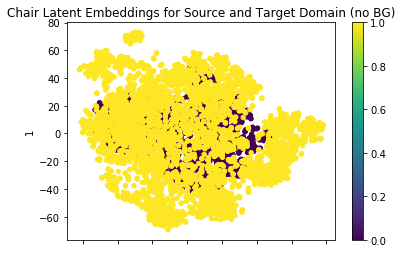

In [59]:
# TSNE for adapted model. Target Domain: no bg 
dann_no_bg_yaml = "configs/domain_adaptation/chair_DA_DANN.yaml"
perform_tsne_experiment(dann_no_bg_yaml)

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 1355/1355 [01:15<00:00, 17.95it/s]


out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [05:56<00:00, 10.77it/s]


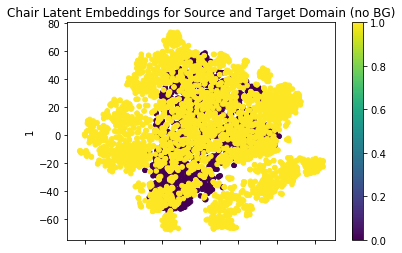

In [58]:
# TSNE for non-adapted model. Target Domain: no bg 
no_adaptation_yaml = "configs/domain_adaptation/chair_noDA.yaml"
perform_tsne_experiment(no_adaptation_yaml)